<a href="https://colab.research.google.com/github/german-cano/CTAO-image-processing-with-ants-algorithm/blob/main/ANTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook used to generate the graphs based os the data provided by CTAO and previously cleaned with the data analysis notebook.

With this notebook I aim to explore some of the possibilities of graph representation of the data. I focus on the representation of the noise within the graph, three types of graph are explored:
- Noise as mean $\mu$ and deviation $\sigma$ obtained from the gaussian fitting on the data analysis notebook. Each value correspond to a different node.
-Noise as mean $\mu$ and deviation $\sigma$ obtained from the gaussian fitting on the data analysis notebook. Both values are included on the same node.
-Noise as an independent graph that will be an individual node in the final graph.

In [ ]:
%%capture
!pip install acopy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import acopy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rc('font', size=12)


In [ ]:
#shortcut for the paths
pth = '/content/drive/MyDrive/TFG/'

In [ ]:
#I donwloaded previusly the data i am intersted in as np.array

#Load data
data = np.load(pth + 'ctadata_raw.npz') # imag, temp, event

imag = data['imag'] # shape (41083,1855),phe charge detected at each pixel
mask = data['mask'] #shape (41083, 1855), whether if each 'imag' value belongs to background noise or not
bckgr = data['bckgr_reduced'] #shape (2,), Background noise expresed as its deviation and mean after fitting the data to a gaussian

In [ ]:
def graphgenerator(data, noise):
  '''
  data: phe charge per pixel, not classified as background
  noise: noise data. it can be a list, tuple or another graph

  '''
  G = nx.Graph()

#cases where the event correspond to pedestal, hence data is empty
  if not data:
    G.add_edge(noise[0], noise[1], weight = 1.)
  else:

#cases where data is not empy (will be empty for pedestals events)

  #graph with noise(mean and deviation) as independent values
    if type(noise) is list and len(noise)>1:

      G.add_edge(noise[0], noise[1], weight = 1.)
      for i in range(len(data)):
        G.add_edge(data[i], noise[0], weight = 1.)
        G.add_edge(data[i], noise[1], weight = 1.)

        for j in range(i+1, len(data)):
          G.add_edge(data[i], data[j], weight = 1./j)
  # graph with noise as tuple, graph...
    else:
      for i in range(len(data)):
        G.add_edge(data[i], noise, weight = 1.)
        for j in range(i+1, len(data)):
          G.add_edge(data[i], data[j], weight = 1./j)

  return G


def ants(G, gen_size, limit):
  '''
  G: Graph where the ants will interate over
  gen_size: number of ants
  limit: number of iterations for each ant
  '''
  #Definition of a colony and the solver with random parameters
  solver = acopy.Solver(rho=.3, q=1)
  colony = acopy.Colony(alpha=1, beta=10)
  Ant = acopy.Ant(alpha = 1, beta = 10)


  tour = solver.solve(G, colony, gen_size= gen_size, limit= limit)
  return tour.path

In [ ]:
def coloredgraph(G, colorbar):
  '''
  This function is meant to be used only with the graphs where each node is
  an independent value. If any node is a tuple or a graph it will return an error.

  G: Graph
  colorbar: boolean, wheter if we want colorbar as legend for node values
  '''
  #Normalize values to map them as colors
  norm = mcolors.Normalize(vmin=min(G.nodes), vmax=max(G.nodes))
  # Choose a colormap
  cmap = plt.cm.viridis

  #Map normalized values to colors
  node_colors = cmap(norm(G.nodes)).tolist()

  #Draw the graph

  nx.draw(G, node_color=node_colors, cmap=cmap, node_size=500)

  # Add colorbar
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
  sm.set_array([])

  if colorbar==True:
    c = plt.colorbar(sm)
    c.set_label('carga de phe', rotation=270, labelpad = 16.)

  plt.savefig('colouredgraph.png', transparent = True)
  plt.show()


In [ ]:
# Some of the registered events are just background noise, here we extract the
# position of arrays that contain valuable data.

useful = []

for i in range(mask.shape[0]):
  a = True # this variable is used to stop the second loop once we encounter the first True value.

  for j in mask[i]:
    if j == True and a == True:
      useful.append(i)
      a = False

    else: pass

In [ ]:
import random

n = random.choice(useful) #select random event to study

aux1 = imag[n].tolist() #here we are selecting the data from the event
aux2 = mask[n].tolist() #mask from the event
aux3 = [aux1[i] for i in range(len(aux1)) if aux2[i] == True] #final list to create the graph (NOT BACKGROUND DATA)
aux4 = [aux1[i] for i in range(len(aux1)) if aux2[i] == False]

In [ ]:
#graph with noise parameters in the same node as a tuple
G = graphgenerator(aux3, tuple(bckgr))

In [ ]:
#change the background data color to identify it on the plot

node_color = []
for i in list(G.nodes):
  if i == tuple(bckgr) :
    node_color.append('red')
  else:
    node_color.append('blue')

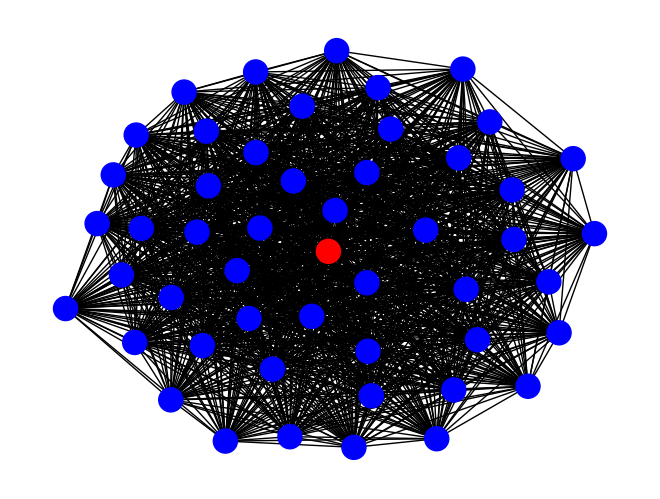

In [ ]:
#How the graph looks like before applying the ants algorithm
nx.draw(G, node_color = node_color)
#plt.savefig('tuplenoise.png')

In [ ]:
tour = ants(G,5,1) #run the ants algorithm on the previous graph

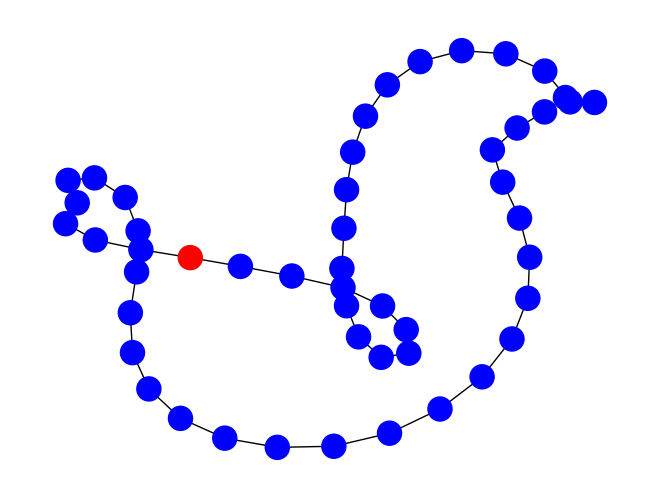

In [ ]:
H = nx.Graph(tour)
nx.draw(H,node_color = node_color)
#plt.savefig('antstuplenoise.png')

In [ ]:
#Now we represent the background data as another graph instead of tuple

P = nx.Graph()
P.add_nodes_from(aux4) #Graph with background data

F = graphgenerator(aux3,P) #graph all data and noise graph

In [ ]:
#change the background data color to identify it on the plot

node_color = []
for i in list(F.nodes):
  if i == P :
    node_color.append('red')
  else:
    node_color.append('blue')

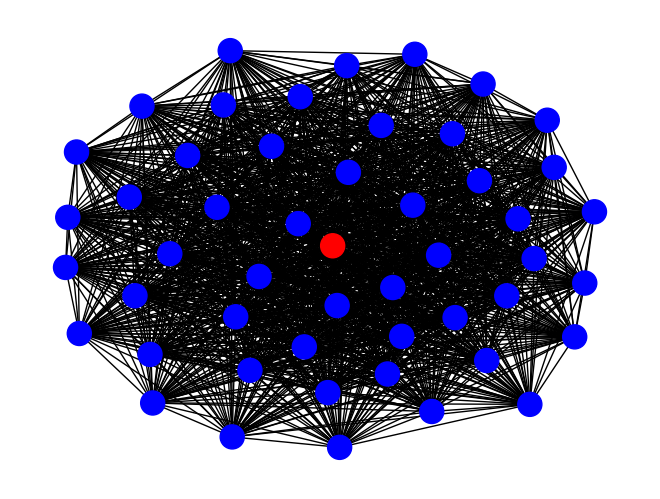

In [ ]:
nx.draw(F,node_color = node_color)
#plt.savefig('noisegraph.png')

In [ ]:
Ftour = ants(F, 5, 1)

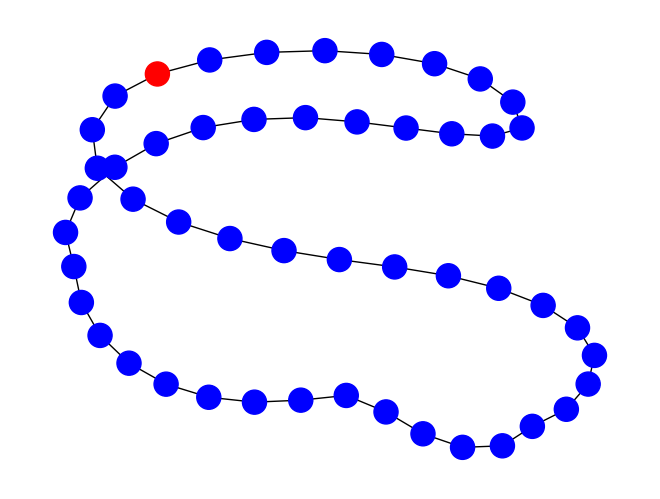

In [ ]:
H2 = nx.Graph(Ftour)
nx.draw(H2,node_color = node_color)
#plt.savefig('antsgraphnoise.png')

In [ ]:
#noise parameters as independent nodes
F = graphgenerator(aux3, bckgr.tolist())


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


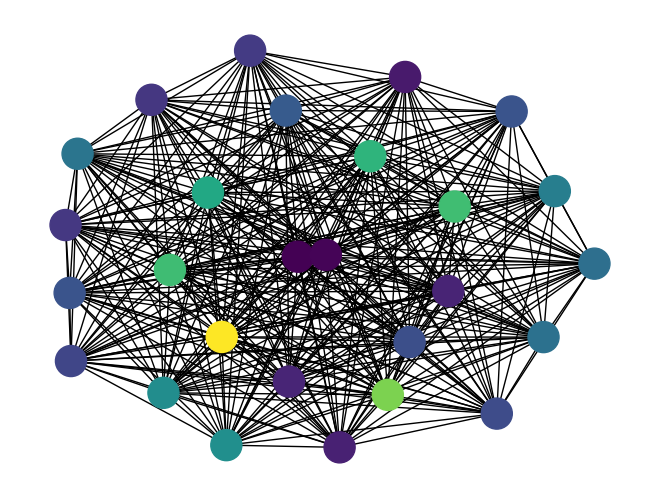

In [ ]:
coloredgraph(F, True)

In [ ]:
Ttour = ants(F,44,88) #high number of ants and iterations to make up for initial randomness

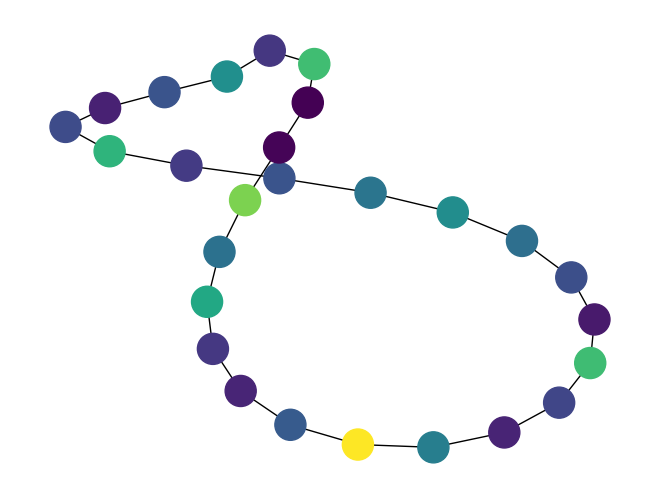

In [ ]:
H3= nx.Graph(Ttour)
coloredgraph(H3, True)#final graph